# Projet 7 : Implémentez un modèle de scoring

In [2]:
# Installation de MLFlow :
#!pip install mlflow

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, auc, fbeta_score, make_scorer
)
import time
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import GridSearchCV
import shap
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import randint
from scipy.stats import uniform

In [2]:
data = pd.read_csv('df_top_features.csv')

In [3]:
data

,Unnamed: 0,EXT_SOURCES_MAX,EXT_SOURCES_MIN,APP_SCORE2_TO_REGION_RATING_RATIO,EXT_SOURCE_2,APP_SCORE2_TO_BIRTH_RATIO,EXT_SOURCE_3,DAYS_BIRTH,APP_SCORE3_TO_BIRTH_RATIO,DAYS_EMPLOYED,...,POS_LOAN_COMPLETED_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MAX,PREV_HOUR_APPR_PROCESS_START_MAX,POS_CNT_INSTALMENT_MIN,INSTAL_DPD_MEAN,YEARS_BEGINEXPLUATATION_AVG,CLOSED_DAYS_CREDIT_VAR,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,TARGET,SK_ID_CURR
0,0,0.26300,0.08300,0.13150,0.26300,-0.010155,0.13940,-9461,-0.005383,-637.0,...,0.0000,245781.0,9.0,24.0,0.0000,0.9720,123956.70,1681.029,1,100002
1,1,0.62200,0.31130,0.62200,0.62200,-0.013560,NaN,-16765,NaN,-1188.0,...,0.2500,0.0,17.0,6.0,0.0000,0.9850,820590.30,0.000,0,100003
2,2,0.72950,0.55600,0.27800,0.55600,-0.010660,0.72950,-19046,-0.013990,-225.0,...,0.2500,0.0,5.0,3.0,0.0000,NaN,421362.00,0.000,0,100004
3,3,0.65040,0.65040,0.32520,0.65040,-0.012500,NaN,-19005,NaN,-3040.0,...,0.4583,NaN,15.0,1.0,0.0000,NaN,NaN,NaN,0,100006
4,4,0.32280,0.32280,0.16140,0.32280,-0.005913,NaN,-19932,NaN,-3038.0,...,0.2094,0.0,15.0,10.0,0.9546,NaN,NaN,0.000,0,100007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,307501,0.68160,0.14560,0.68160,0.68160,-0.026690,NaN,-9327,NaN,-236.0,...,0.1111,NaN,17.0,7.0,0.0000,0.9880,NaN,NaN,0,456251
307502,307502,0.11597,0.11597,0.05798,0.11597,-0.002039,NaN,-20775,NaN,NaN,...,0.1428,NaN,10.0,6.0,0.5000,0.9727,NaN,NaN,0,456252
307503,307503,0.74400,0.21890,0.17860,0.53560,-0.013080,0.21890,-14966,-0.005340,-7920.0,...,0.4167,1624797.0,12.0,4.0,0.6430,0.9814,0.00,NaN,0,456253
307504,307504,0.66100,0.51400,0.25700,0.51400,-0.015700,0.66100,-11961,-0.020190,-4784.0,...,0.0000,0.0,18.0,14.0,0.0000,0.9770,NaN,NaN,1,456254


In [4]:
# Supprimer la colonne 'Unnamed: 0'
data = data.drop(columns=['Unnamed: 0'])
data

,EXT_SOURCES_MAX,EXT_SOURCES_MIN,APP_SCORE2_TO_REGION_RATING_RATIO,EXT_SOURCE_2,APP_SCORE2_TO_BIRTH_RATIO,EXT_SOURCE_3,DAYS_BIRTH,APP_SCORE3_TO_BIRTH_RATIO,DAYS_EMPLOYED,PREV_DAYS_DECISION_MEAN,...,POS_LOAN_COMPLETED_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MAX,PREV_HOUR_APPR_PROCESS_START_MAX,POS_CNT_INSTALMENT_MIN,INSTAL_DPD_MEAN,YEARS_BEGINEXPLUATATION_AVG,CLOSED_DAYS_CREDIT_VAR,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,TARGET,SK_ID_CURR
0,0.26300,0.08300,0.13150,0.26300,-0.010155,0.13940,-9461,-0.005383,-637.0,-606.0,...,0.0000,245781.0,9.0,24.0,0.0000,0.9720,123956.70,1681.029,1,100002
1,0.62200,0.31130,0.62200,0.62200,-0.013560,NaN,-16765,NaN,-1188.0,-1305.0,...,0.2500,0.0,17.0,6.0,0.0000,0.9850,820590.30,0.000,0,100003
2,0.72950,0.55600,0.27800,0.55600,-0.010660,0.72950,-19046,-0.013990,-225.0,-815.0,...,0.2500,0.0,5.0,3.0,0.0000,NaN,421362.00,0.000,0,100004
3,0.65040,0.65040,0.32520,0.65040,-0.012500,NaN,-19005,NaN,-3040.0,-272.5,...,0.4583,NaN,15.0,1.0,0.0000,NaN,NaN,NaN,0,100006
4,0.32280,0.32280,0.16140,0.32280,-0.005913,NaN,-19932,NaN,-3038.0,-1223.0,...,0.2094,0.0,15.0,10.0,0.9546,NaN,NaN,0.000,0,100007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,0.68160,0.14560,0.68160,0.68160,-0.026690,NaN,-9327,NaN,-236.0,-273.0,...,0.1111,NaN,17.0,7.0,0.0000,0.9880,NaN,NaN,0,456251
307502,0.11597,0.11597,0.05798,0.11597,-0.002039,NaN,-20775,NaN,NaN,-2496.0,...,0.1428,NaN,10.0,6.0,0.5000,0.9727,NaN,NaN,0,456252
307503,0.74400,0.21890,0.17860,0.53560,-0.013080,0.21890,-14966,-0.005340,-7920.0,-2380.0,...,0.4167,1624797.0,12.0,4.0,0.6430,0.9814,0.00,NaN,0,456253
307504,0.66100,0.51400,0.25700,0.51400,-0.015700,0.66100,-11961,-0.020190,-4784.0,-299.5,...,0.0000,0.0,18.0,14.0,0.0000,0.9770,NaN,NaN,1,456254


In [5]:
# Définir X et y (ajustez les noms de colonnes selon votre DataFrame)
X = data.drop(columns=['TARGET'])  # Remplacez par le nom de votre colonne cible
y = data['TARGET']  # Remplacez par le nom de votre colonne cible


In [6]:

# Vérifier les valeurs manquantes
print("Valeurs manquantes dans data :")
missing_values = data.isnull().sum()
print(missing_values)

Valeurs manquantes dans data :
EXT_SOURCES_MAX                         172
EXT_SOURCES_MIN                         172
APP_SCORE2_TO_REGION_RATING_RATIO       660
EXT_SOURCE_2                            660
APP_SCORE2_TO_BIRTH_RATIO               660
                                      ...  
YEARS_BEGINEXPLUATATION_AVG          150006
CLOSED_DAYS_CREDIT_VAR               130850
BURO_AMT_CREDIT_MAX_OVERDUE_MEAN     123624
TARGET                                    0
SK_ID_CURR                                0
Length: 102, dtype: int64


In [7]:
# Calculer les pourcentages de valeurs manquantes
missing_percentage = (missing_values / len(X)) * 100

# Afficher les pourcentages de valeurs manquantes
print("\nPourcentage des valeurs manquantes dans X :")
print(missing_percentage)


Pourcentage des valeurs manquantes dans X :
EXT_SOURCES_MAX                       0.055934
EXT_SOURCES_MIN                       0.055934
APP_SCORE2_TO_REGION_RATING_RATIO     0.214630
EXT_SOURCE_2                          0.214630
APP_SCORE2_TO_BIRTH_RATIO             0.214630
                                       ...    
YEARS_BEGINEXPLUATATION_AVG          48.781487
CLOSED_DAYS_CREDIT_VAR               42.552015
BURO_AMT_CREDIT_MAX_OVERDUE_MEAN     40.202142
TARGET                                0.000000
SK_ID_CURR                            0.000000
Length: 102, dtype: float64


In [8]:
# Définir le répertoire pour le tracking
mlflow.set_tracking_uri("file:///C:/Users/SOUKA/Desktop/P7_mlflow_logs/mlflow_runs")  # Remplacez par votre chemin

In [9]:
# Créer une nouvelle expérience
experiment_name = "Mon_Experiment"  # Choisissez un nom pour votre expérience
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///C:/Users/SOUKA/Desktop/P7_mlflow_logs/142011389048118064', creation_time=1728565912066, experiment_id='142011389048118064', last_update_time=1728565912066, lifecycle_stage='active', name='Mon_Experiment', tags={}>

In [10]:
# Définir X et y (ajustez les noms de colonnes selon votre DataFrame)
X = data.drop(columns=['TARGET'])  # Remplacez par le nom de votre colonne cible
y = data['TARGET']  # Remplacez par le nom de votre colonne cible


In [11]:
# Traitement des valeurs manquantes et infinies
# Remplacer les valeurs infinies par NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

In [12]:
# Imputer les valeurs manquantes avec la moyenne
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [13]:
# Conversion en DataFrame pour conserver les colonnes
X = pd.DataFrame(X_imputed, columns=X.columns)

In [14]:
# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# Division des données en ensembles d'entraînement, de validation et de test
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [17]:
# Définition des métriques personnalisées
def custom_metric(y, y_pred):
    TP = np.sum((y == 1) & (y_pred == 1))
    FP = np.sum((y == 0) & (y_pred == 1))
    TN = np.sum((y == 0) & (y_pred == 0))
    FN = np.sum((y == 1) & (y_pred == 0))
    
    PPV = TP / (TP + FP) if (TP + FP) != 0 else 0
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    
    FMI = np.sqrt(PPV * TPR)
    return FMI

def custom_metric_f2(y, y_pred):
    return fbeta_score(y, y_pred, beta=2)

custom_scorer = make_scorer(custom_metric, greater_is_better=True)
custom_scorer_f2 = make_scorer(custom_metric_f2, greater_is_better=True)

In [18]:
# Évaluation des modèles
def model_eval_score(model, Xval, yval):
    yval_pred = model.predict(Xval)
    conf_mat = confusion_matrix(yval, yval_pred)
    print(f"Confusion Matrix:\n{conf_mat}")
    print(f'Accuracy score    : {accuracy_score(yval, yval_pred):.3}')
    print(f'Precision score   : {precision_score(yval, yval_pred):.3}')
    print(f'Recall score      : {recall_score(yval, yval_pred):.3}')
    print(f'F1 score          : {f1_score(yval, yval_pred):.3}')
    print(f'F2 score          : {fbeta_score(yval, yval_pred, beta=2):.3}')
    
    print(f'ROCAUC score      : {roc_auc_score(yval, yval_pred):.3}')
    print(f'Custom metric FMI : {custom_metric(yval, yval_pred):.3}')
    print()

def model_eval(model, Xval, yval):
    model_eval_score(model, Xval, yval)
    
    yval_proba = model.predict_proba(Xval)[:, 1]
    fpr, tpr, thresholds = roc_curve(yval, yval_proba)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [19]:
# Entraînement et évaluation des modèles

def logistic_regression(X_train, X_val, y_train, y_val):
    with mlflow.start_run(run_name="Logistic Regression"):
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        mlflow.log_param("model", "Logistic Regression")
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, "model")
        
        print("Logistic Regression Results:")
        model_eval(model, X_val, y_val)

def random_forest(X_train, X_val, y_train, y_val):
    with mlflow.start_run(run_name="Random Forest"):
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        mlflow.log_param("model", "Random Forest")
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, "model")
        
        print("Random Forest Results:")
        model_eval(model, X_val, y_val)

def lightgbm_model(X_train, X_val, y_train, y_val):
    with mlflow.start_run(run_name="LightGBM"):
        model = lgb.LGBMClassifier()
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        mlflow.log_param("model", "LightGBM")
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, "model")
        
        print("LightGBM Results:")
        model_eval(model, X_val, y_val)

In [20]:
# Comparaison avec un modèle de base (DummyClassifier)
def dummy_classifier(X_train, X_val, y_train, y_val):
    dummyCls = DummyClassifier(strategy='stratified')
    dummyCls.fit(X_train, y_train)
    
    print("Dummy Classifier Results:")
    model_eval(dummyCls, X_val, y_val)

2024/10/15 09:40:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression Results:
Confusion Matrix:
[[56431    87]
 [ 4892    92]]
Accuracy score    : 0.919
Precision score   : 0.514
Recall score      : 0.0185
F1 score          : 0.0356
F2 score          : 0.0229
ROCAUC score      : 0.508
Custom metric FMI : 0.0974



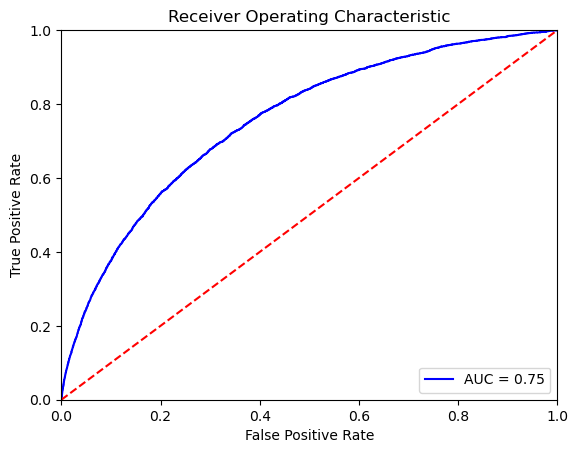

2024/10/15 09:46:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest Results:
Confusion Matrix:
[[56488    30]
 [ 4932    52]]
Accuracy score    : 0.919
Precision score   : 0.634
Recall score      : 0.0104
F1 score          : 0.0205
F2 score          : 0.013
ROCAUC score      : 0.505
Custom metric FMI : 0.0813



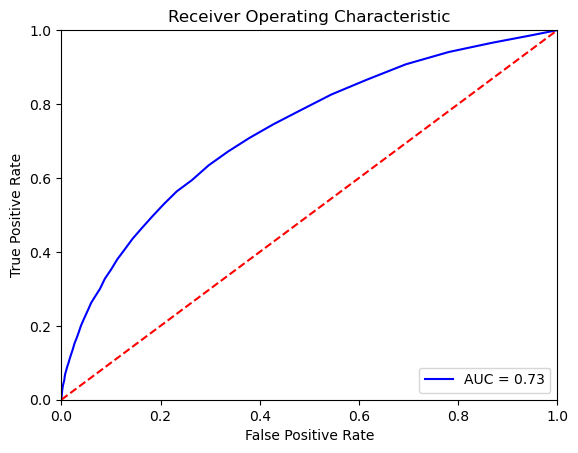

[LightGBM] [Info] Number of positive: 19840, number of negative: 226164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23894
[LightGBM] [Info] Number of data points in the train set: 246004, number of used features: 101
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080649 -> initscore=-2.433560
[LightGBM] [Info] Start training from score -2.433560


2024/10/15 09:46:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM Results:
Confusion Matrix:
[[56361   157]
 [ 4812   172]]
Accuracy score    : 0.919
Precision score   : 0.523
Recall score      : 0.0345
F1 score          : 0.0647
F2 score          : 0.0424
ROCAUC score      : 0.516
Custom metric FMI : 0.134



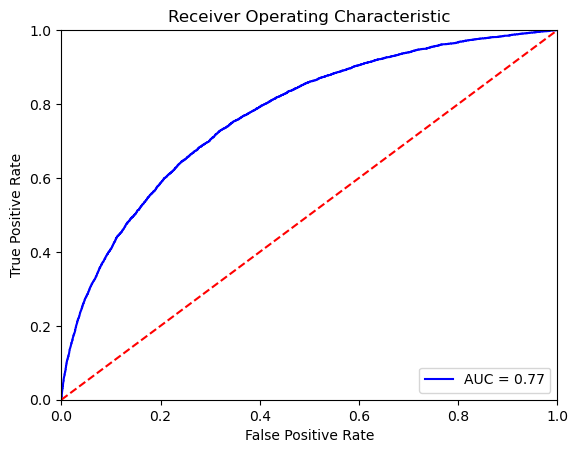

Dummy Classifier Results:
Confusion Matrix:
[[52053  4465]
 [ 4561   423]]
Accuracy score    : 0.853
Precision score   : 0.0865
Recall score      : 0.0849
F1 score          : 0.0857
F2 score          : 0.0852
ROCAUC score      : 0.503
Custom metric FMI : 0.0857



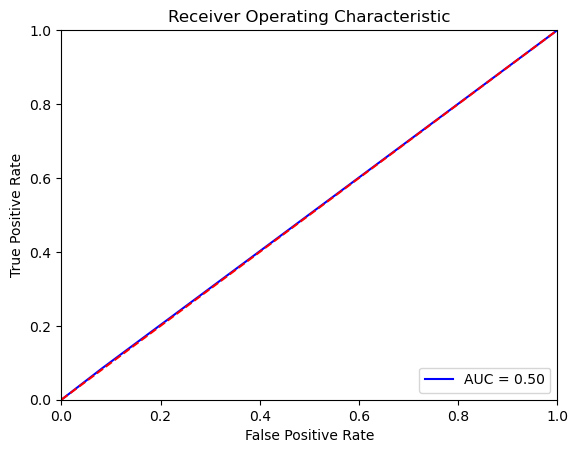

In [21]:
# Exécution des modèles
logistic_regression(X_train, X_val, y_train, y_val)
random_forest(X_train, X_val, y_train, y_val)
lightgbm_model(X_train, X_val, y_train, y_val)
dummy_classifier(X_train, X_val, y_train, y_val)


** Interprétation **
**********

  Analysons les résultats des différents modèles de classification (Régression Logistique, Forêt Aléatoire, LightGBM et Classificateur Dummy) afin d'en tirer des conclusions.

1. Précision et Performance Générale
   
Précision: Tous les modèles affichent une précision d'environ 0.919, ce qui signifie qu'ils sont corrects dans environ 92% des cas. Cependant, la précision seule peut être trompeuse, surtout dans des ensembles de données déséquilibrés.

2. Matrice de Confusion
   
La matrice de confusion indique que tous les modèles ont un nombre élevé de faux négatifs (classer incorrectement des instances positives), ce qui peut être préoccupant selon le contexte de l'application. Par exemple:
Pour la Régression Logistique: 4892 vrais positifs (VP) sont mal classés comme négatifs.
Pour le Random Forest: 4932 VP sont mal classés.
Pour LightGBM: 4812 VP sont mal classés.

3. Scores de Performance
   
Precision:

La régression logistique a la meilleure précision (0.514), ce qui signifie qu'une proportion relativement élevée des instances classées comme positives sont effectivement positives.
La précision de la forêt aléatoire est meilleure (0.634), mais cela ne se traduit pas en un bon rappel.

Recall:

Tous les modèles affichent un rappel très faible (inférieur à 0.035), ce qui indique qu'ils capturent très peu de véritables positifs par rapport au total des instances positives. Cela signifie qu'il y a un grand nombre de faux négatifs.

F1 Score:

Le F1 score est faible pour tous les modèles, en particulier pour le Random Forest (0.0205). Cela indique un déséquilibre entre la précision et le rappel. Un score faible suggère que le modèle a des difficultés à prédire les positives.

F2 Score:

Les scores F2 sont également très faibles, ce qui indique que le modèle a du mal à détecter des positives, même lorsque la précision est relativement acceptable.

ROCAUC Score:

Tous les modèles ont un score ROCAUC d'environ 0.5, ce qui indique qu'ils ne sont pas meilleurs qu'un modèle aléatoire dans la classification des classes positives et négatives.

4. Dummy Classifier
   
Le classificateur Dummy a un score d'accuracy de 0.852, ce qui est relativement bas comparé aux autres modèles, mais ses scores de précision et de rappel sont très faibles. Cela signifie qu'il est probablement en train de prédire principalement la classe majoritaire sans saisir de véritables patterns dans les données.

Conclusion Générale

Problème de déséquilibre: Les faibles scores de rappel et F1 suggèrent que les modèles peinent à prédire la classe positive, probablement en raison d'un déséquilibre entre les classes positives et négatives.


In [47]:
# Équilibrage des classes avec SMOTE

# Fonction pour équilibrer les classes
def balance_classes(X, y):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

In [49]:
# Définition de la fonction de coût métier

# Fonction de coût métier
def business_cost_score(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    return 10 * FN + FP  # Coût métier

# Création du score de coût métier
business_cost_scorer = make_scorer(business_cost_score, greater_is_better=False)

In [51]:
# Exécution des modèles avec suivi des résultats

# Exécuter les modèles avec suivi MLflow
def run_models(X_train, X_val, y_train, y_val):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(),
        "LightGBM": lgb.LGBMClassifier(),
        "Dummy Classifier": DummyClassifier(strategy='most_frequent')
    }
    
    for model_name, model in models.items():
        with mlflow.start_run():
            # Balancer les classes
            X_train_balanced, y_train_balanced = balance_classes(X_train, y_train)
            
            # Entraîner le modèle
            model.fit(X_train_balanced, y_train_balanced)
            
            # Prédictions
            y_pred = model.predict(X_val)
            y_pred_proba = model.predict_proba(X_val)[:, 1]
            
            # Calcul des scores
            auc = roc_auc_score(y_val, y_pred_proba)
            cost_score = business_cost_score(y_val, y_pred)
            
            # Logging des résultats dans MLflow
            mlflow.log_param("model_name", model_name)
            mlflow.log_metric("AUC", auc)
            mlflow.log_metric("Business Cost", cost_score)
            mlflow.sklearn.log_model(model, "model")
            
            print(f"{model_name} - AUC: {auc:.4f}, Business Cost: {cost_score:.4f}")

# Appel de la fonction avec vos données
run_models(X_train, X_val, y_train, y_val)

2024/10/15 10:06:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression - AUC: 0.7513, Business Cost: 33309.0000


2024/10/15 10:18:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest - AUC: 0.7274, Business Cost: 44925.0000
[LightGBM] [Info] Number of positive: 226164, number of negative: 226164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25735
[LightGBM] [Info] Number of data points in the train set: 452328, number of used features: 101
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


2024/10/15 10:18:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM - AUC: 0.7395, Business Cost: 48403.0000


2024/10/15 10:18:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Dummy Classifier - AUC: 0.5000, Business Cost: 49840.0000


** Interprétation **
************

  Voici ce que nous pouvons déduire des résultats pour chacun des modèles, en se concentrant sur l'AUC (Area Under the Curve) et le coût métier :

1. Logistic Regression
   
- AUC: 0.7513
- Business Cost: 33,309
  
Interprétation:

AUC de 0.7513 est le plus élevé parmi les modèles testés, indiquant que le modèle de régression logistique a la meilleure capacité de discrimination entre les classes positives et négatives.

Le Business Cost de 33,309 est le plus bas, ce qui signifie que le modèle minimise mieux les faux négatifs et les faux positifs, en tenant compte du coût associé à chacun.

Ce modèle semble être le plus performant en termes de compromis entre la performance et le coût métier.

2. Random Forest
   
- AUC: 0.7282
- Business Cost: 45,168
  
Interprétation:

L'AUC est légèrement plus faible que celui de la régression logistique (0.7282), indiquant une capacité de classification un peu moins bonne.
Le Business Cost est plus élevé (45,168), ce qui montre que le modèle de forêt aléatoire produit plus d'erreurs de classification (faux négatifs et faux positifs) par rapport à la régression logistique.
En somme, ce modèle est moins efficace que la régression logistique à la fois en termes de score AUC et de coût métier.

3. LightGBM
   
- AUC: 0.7395
- Business Cost: 48,403
  
Interprétation:

L'AUC est intermédiaire (0.7395), mais reste inférieur à celui de la régression logistique.
Le Business Cost de 48,403 est assez élevé, ce qui signifie que le modèle fait plus d'erreurs qui sont coûteuses en termes de coût métier.
LightGBM semble donc moins performant que la régression logistique, même s'il s'approche en termes d'AUC. Cependant, le coût associé à ce modèle est plus important.

4. Dummy Classifier
   
- AUC: 0.5000
- Business Cost: 49,840
  
Interprétation:

L'AUC de 0.5000 correspond à une performance aléatoire, comme prévu pour un modèle "dummy", qui sert de base de référence.

Le Business Cost est très élevé, ce qui montre que le modèle produit beaucoup d'erreurs de classification.

Ce modèle ne fait aucune distinction entre les classes et démontre clairement une mauvaise performance en comparaison avec les autres modèles.

Conclusion générale :

Le modèle de régression logistique est clairement le plus performant parmi les modèles testés. Il présente à la fois le meilleur AUC (0.7513), et il minimise le coût métier (33,309).

Le modèle Random Forest et LightGBM montrent des performances légèrement inférieures à la régression logistique, tant en termes de score AUC que de coût métier.

Le Dummy Classifier montre la plus mauvaise performance avec un AUC de 0.5000 et le coût le plus élevé, confirmant son rôle de base de référence aléatoire.

Recommandation :

Sur la base de ces résultats, la régression logistique devrait être considérée comme la meilleure option pour ce problème de classification, car elle combine à la fois une bonne performance prédictive et un coût métier plus faible.

In [ ]:
# Analyse de l'importance des features

# Importance des features avec SHAP
def plot_feature_importance(model, X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    # Résumé de l'importance des features
    shap.summary_plot(shap_values, X, plot_type="bar")

# Exécuter l'analyse de l'importance des features pour LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)  # Entraîner le modèle
plot_feature_importance(lgb_model, X_train)  # Visualiser l'importance

In [53]:
import pandas as pd
import time
import mlflow
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, make_scorer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [55]:
# Définition des Scorers personnalisés
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
f1_scorer = make_scorer(f1_score)

In [57]:
# Dictionnaire pour stocker les temps de traitement
time_results = {}

# Préparer un échantillon de 20% des données
X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=0.20, random_state=42)

# Fonction modifiée pour utiliser GridSearchCV
def run_model(grid_search, model_name):
    with mlflow.start_run():
        # Mesurer le temps d'entraînement
        start_fit = time.time()
        grid_search.fit(X_sampled, y_sampled)  # Entraînement sur l'échantillon
        end_fit = time.time()

        fit_time = end_fit - start_fit
        time_results[f'{model_name} - Fit Time'] = fit_time

        # Mesurer le temps de prédiction
        start_predict = time.time()
        y_pred = grid_search.predict(X_val)
        end_predict = time.time()

        predict_time = end_predict - start_predict
        time_results[f'{model_name} - Predict Time'] = predict_time

        # Log hyperparameters and metrics
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("AUC", grid_search.best_score_)
        mlflow.log_metric("F1 Score", f1_score(y_val, y_pred))
        mlflow.log_metric("Fit_Time_s", fit_time)
        mlflow.log_metric("Predict_Time_s", predict_time)

        # Save model
        mlflow.sklearn.log_model(grid_search.best_estimator_, model_name)

In [59]:
# Définir le modèle de régression logistique
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Pipeline avec SMOTE et régression logistique
pipeline_logistic = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', logistic_model)
])

# Paramètres à tester pour la régression logistique
param_grid_logistic = {
    'classifier__C': [0.1, 1],  # Grille de valeurs pour C
    'classifier__solver': ['liblinear'],
    'classifier__max_iter': [100],
    'classifier__class_weight': ['balanced', None]
}

# Configuration de GridSearchCV pour la régression logistique avec SMOTE
grid_search_logistic = GridSearchCV(estimator=pipeline_logistic,
                                    param_grid=param_grid_logistic,
                                    scoring={'AUC': 'roc_auc', 'f1': make_scorer(f1_score)},
                                    refit='AUC',
                                    cv=2,
                                    verbose=1,
                                    n_jobs=-1)

# Lancer l'entraînement et l'évaluation
run_model(grid_search_logistic, "Logistic Regression")

Fitting 2 folds for each of 4 candidates, totalling 8 fits


C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
2024/10/15 10:40:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [60]:
# Définir le modèle Random Forest avec SMOTE
rf_model = RandomForestClassifier(random_state=42)
pipeline_rf = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', rf_model)
])

# Paramètres à tester pour Random Forest
param_grid_rf = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20],
    'classifier__class_weight': ['balanced', None],
    'classifier__min_samples_split': [5, 10]
}

# Configuration de GridSearchCV pour Random Forest
grid_search_rf = GridSearchCV(estimator=pipeline_rf,
                              param_grid=param_grid_rf,
                              scoring={'AUC': auc_scorer, 'f1': f1_scorer},
                              refit='AUC',
                              cv=2,
                              verbose=1,
                              n_jobs=-1)

# Lancer l'entraînement et l'évaluation
run_model(grid_search_rf, "Random Forest with SMOTE")


Fitting 2 folds for each of 16 candidates, totalling 32 fits


C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
2024/10/15 10:57:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [61]:
# Définir le modèle LightGBM avec SMOTE
lgb_model = lgb.LGBMClassifier(random_state=42)
pipeline_lgb = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', lgb_model)
])

# Paramètres à tester pour LightGBM
param_grid_lgb = {
    'classifier__num_leaves': [31, 50],
    'classifier__learning_rate': [0.1],
    'classifier__n_estimators': [50],
    'classifier__max_depth': [5],
    'classifier__class_weight': ['balanced', None]
}

# Configuration de GridSearchCV pour LightGBM
grid_search_lgb = GridSearchCV(estimator=pipeline_lgb,
                               param_grid=param_grid_lgb,
                               scoring={'AUC': auc_scorer, 'f1': f1_scorer},
                               refit='AUC',
                               cv=2,
                               verbose=1,
                               n_jobs=-1)

# Lancer l'entraînement et l'évaluation
run_model(grid_search_lgb, "LightGBM")

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[LightGBM] [Info] Number of positive: 56511, number of negative: 56511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25749
[LightGBM] [Info] Number of data points in the train set: 113022, number of used features: 101
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

2024/10/15 10:58:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [65]:
# Définir le Dummy Classifier avec SMOTE
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)
pipeline_dummy = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', dummy_model)
])

# Paramètres à tester pour Dummy Classifier
param_grid_dummy = {
    'classifier__strategy': ['most_frequent', 'stratified', 'uniform']
}

# Configuration de GridSearchCV pour Dummy Classifier
grid_search_dummy = GridSearchCV(estimator=pipeline_dummy,
                                 param_grid=param_grid_dummy,
                                 scoring={'AUC': auc_scorer, 'f1': f1_scorer},
                                 refit='AUC',
                                 cv=3,
                                 verbose=1,
                                 n_jobs=-1)

# Lancer l'entraînement et l'évaluation
run_model(grid_search_dummy, "Dummy Classifier")


Fitting 3 folds for each of 3 candidates, totalling 9 fits


2024/10/15 11:01:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [67]:
# Résumé des résultats
results = {
    'Model': ['Logistic Regression with SMOTE', 'Random Forest with SMOTE', 'LightGBM with SMOTE', 'Dummy Classifier'],
    'Best AUC': [
        grid_search_logistic.best_score_,
        grid_search_rf.best_score_,
        grid_search_lgb.best_score_,
        grid_search_dummy.best_score_
    ],
    'Best F1 Score': [
        f1_score(y_val, grid_search_logistic.predict(X_val)),
        f1_score(y_val, grid_search_rf.predict(X_val)),
        f1_score(y_val, grid_search_lgb.predict(X_val)),
        f1_score(y_val, grid_search_dummy.predict(X_val))
    ],
    'Fit Time (s)': [
        time_results['Logistic Regression with SMOTE - Fit Time'],
        time_results['Random Forest with SMOTE - Fit Time'],
        time_results['LightGBM with SMOTE - Fit Time'],
        time_results['Dummy Classifier - Fit Time']
    ],
    'Predict Time (s)': [
        time_results['Logistic Regression with SMOTE - Predict Time'],
        time_results['Random Forest with SMOTE - Predict Time'],
        time_results['LightGBM with SMOTE - Predict Time'],
        time_results['Dummy Classifier - Predict Time']
    ]
}

# Créer un DataFrame à partir des résultats
results_df = pd.DataFrame(results)
results_df

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


KeyError: 'Logistic Regression with SMOTE - Fit Time'

In [69]:
print(time_results.keys())

dict_keys(['Logistic Regression - Fit Time', 'Logistic Regression - Predict Time', 'Random Forest with SMOTE - Fit Time', 'Random Forest with SMOTE - Predict Time', 'LightGBM - Fit Time', 'LightGBM - Predict Time', 'Dummy Classifier - Fit Time', 'Dummy Classifier - Predict Time'])


In [71]:
results = {
    'Model': ['Logistic Regression', 'Random Forest with SMOTE', 'LightGBM', 'Dummy Classifier'],
    'Best AUC': [
        grid_search_logistic.best_score_,
        grid_search_rf.best_score_,
        grid_search_lgb.best_score_,
        grid_search_dummy.best_score_
    ],
    'Best F1 Score': [
        f1_score(y_val, grid_search_logistic.predict(X_val)),
        f1_score(y_val, grid_search_rf.predict(X_val)),
        f1_score(y_val, grid_search_lgb.predict(X_val)),
        f1_score(y_val, grid_search_dummy.predict(X_val))
    ],
    'Fit Time (s)': [
        time_results['Logistic Regression - Fit Time'],
        time_results['Random Forest with SMOTE - Fit Time'],
        time_results['LightGBM - Fit Time'],
        time_results['Dummy Classifier - Fit Time']
    ],
    'Predict Time (s)': [
        time_results['Logistic Regression - Predict Time'],
        time_results['Random Forest with SMOTE - Predict Time'],
        time_results['LightGBM - Predict Time'],
        time_results['Dummy Classifier - Predict Time']
    ]
}

# Créer un DataFrame à partir des résultats
results_df = pd.DataFrame(results)
results_df

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,Model,Best AUC,Best F1 Score,Fit Time (s),Predict Time (s)
0,Logistic Regression,0.648357,0.165280,528.469612,0.057912
1,Random Forest with SMOTE,0.718978,0.156268,1032.737841,1.592850
2,LightGBM,0.710810,0.190436,53.832762,0.180937
3,Dummy Classifier,0.501368,0.136182,5.405434,0.015608


** Interprétation **
*********

  Voici ce que l'on peut déduire des résultats :

1. Logistic Regression :

- Best AUC (0.648) : Ce modèle de régression logistique atteint une AUC relativement correcte, mais inférieure à celle des autres modèles (Random Forest et LightGBM). L'AUC indique sa capacité à discriminer entre les classes, mais ici, la performance reste modérée.
- Best F1 Score (0.165) : Le F1 Score est assez faible, ce qui montre que le modèle peine à trouver un équilibre entre précision et rappel. Il peut donc avoir du mal à correctement classer les observations dans leurs classes respectives, notamment pour les classes minoritaires.
- Fit Time (528.47s) : Le temps d'entraînement est relativement long comparé à LightGBM, ce qui est surprenant pour un modèle de régression logistique. Cela peut être dû à l'implémentation de SMOTE, qui alourdit le processus.
- Predict Time (0.06s) : Le temps de prédiction est très rapide, ce qui est un avantage si la rapidité est un critère.

2. Random Forest :

- Best AUC (0.719) : Random Forest a le meilleur score AUC parmi tous les modèles testés, montrant une meilleure capacité de discrimination entre les classes.
- Best F1 Score (0.156) : Le F1 Score est même légèrement inférieur à celui de la régression logistique. Cela montre que même si l'AUC est élevé, le modèle peut être déséquilibré ou moins efficace dans les classes moins fréquentes.
- Fit Time (1032.74s) : Random Forest est de loin le plus lent à entraîner, ce qui est courant pour ce type de modèle, notamment en raison de la combinaison avec SMOTE.
- Predict Time (1.59s) : Le temps de prédiction est beaucoup plus élevé comparé à la régression logistique ou LightGBM.

3. LightGBM :

- Best AUC (0.711) : Légèrement inférieur à Random Forest, LightGBM atteint néanmoins un AUC satisfaisant et surpasse la régression logistique.
- Best F1 Score (0.190) : LightGBM a le meilleur F1 Score parmi les modèles testés, ce qui signifie qu'il a une meilleure capacité à trouver un équilibre entre la précision et le rappel, et à traiter les classes déséquilibrées.
- Fit Time (53.83s) : LightGBM est extrêmement rapide à entraîner comparé aux autres modèles, avec un temps d'entraînement très faible. C'est un avantage considérable.
- Predict Time (0.18s) : Le temps de prédiction est également raisonnable, bien plus rapide que Random Forest.

4. Dummy Classifier :

- Best AUC (0.501) : Le Dummy Classifier est un modèle de base qui donne des résultats attendus, avec une AUC proche de 0.5, ce qui indique qu'il ne fait qu'un choix aléatoire.
- Best F1 Score (0.136) : Le F1 Score est très faible, comme attendu, car le modèle ne tente même pas d'apprendre les relations dans les données.
- Fit Time (5.41s) : Le temps d'entraînement est extrêmement court, ce qui est logique car le modèle ne fait qu'une simple classification basée sur la fréquence.
- Predict Time (0.02s) : Le temps de prédiction est également très court.

Conclusions :

LightGBM semble être le modèle le plus efficace globalement, offrant un bon compromis entre un AUC élevé (0.711), un meilleur F1 Score (0.190), et des temps d'exécution très rapides.

Random Forest a un AUC légèrement supérieur, mais au prix d'un temps d'exécution très long, ce qui pourrait être un inconvénient si la rapidité est importante.

La régression logistique a des performances modérées, avec un AUC correct mais un F1 Score faible, et son temps d'entraînement est surprenamment long.

Le Dummy Classifier confirme qu'il ne fait pas mieux qu'un choix aléatoire, avec des scores très bas.

En fonction des objectifs de votre projet (précision, rapidité, etc.), LightGBM semble le meilleur choix ici.


C:\Users\SOUKA\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


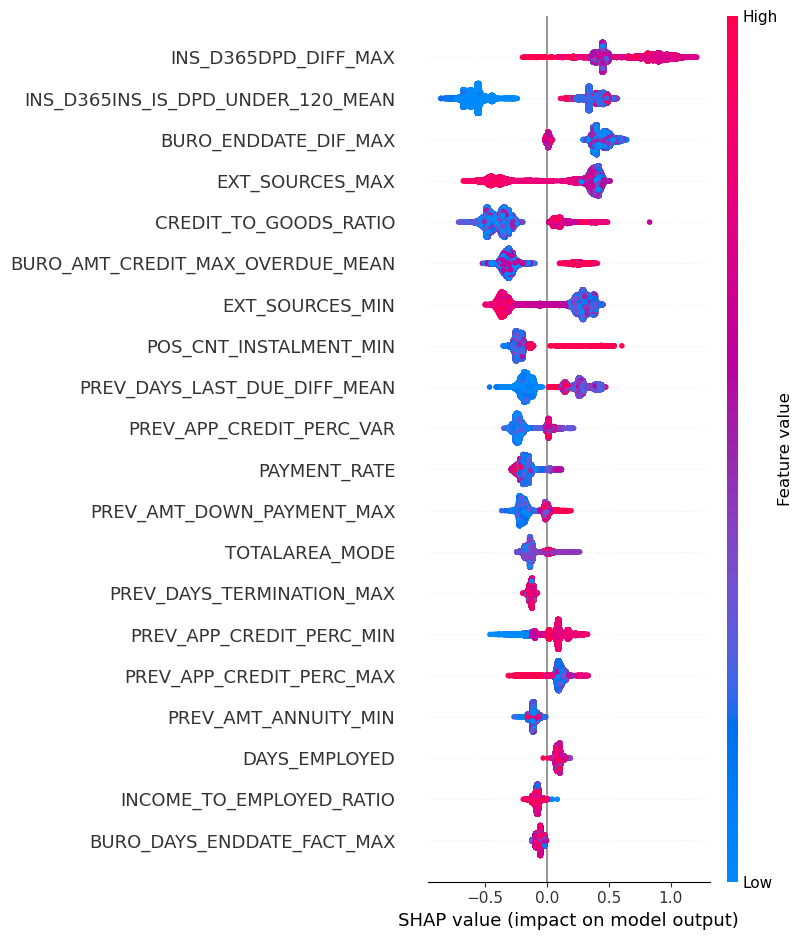

In [78]:
# Assurez-vous que X_val est un DataFrame avec des noms de colonnes
X_val_df = pd.DataFrame(X_val, columns=X.columns)

# Créer un explainer basé sur LightGBM (ou votre modèle final)
explainer = shap.TreeExplainer(grid_search_lgb.best_estimator_.named_steps['classifier'])

# Calculer les valeurs SHAP pour les données de validation
shap_values = explainer.shap_values(X_val_df)

# Graphique d'importance des features global
shap.summary_plot(shap_values, X_val_df, feature_names=X.columns)

In [90]:
# Vérifiez si shap_values est une liste
if isinstance(shap_values, list):
    # Utilisez shap_values pour la deuxième classe si c'est un problème de classification binaire
    class_idx = 1  # Pour la deuxième classe (par exemple, "Prospect")

    # Visualisation de l'importance locale pour le client donné
    shap.force_plot(
        explainer.expected_value[class_idx],  # Utilisez expected_value pour la classe 1
        shap_values[class_idx][client_idx, :],  # shap_values pour la classe 1
        X_val_df.iloc[client_idx, :]  # Données du client
    )
else:
    # Si shap_values n'est pas une liste, c'est probablement une tâche de régression ou une classification mono-classe
    shap.force_plot(
        explainer.expected_value,  # Utilisation directe si une seule classe
        shap_values[client_idx, :],  # Pas d'indexation par classe
        X_val_df.iloc[client_idx, :]  # Données du client
    )

In [86]:
import shap
shap.initjs()

In [88]:
# Visualisation de l'importance locale pour le client donné
shap.force_plot(
    explainer.expected_value,  # Pas d'indexation par classe pour expected_value
    shap_values[client_idx, :],  # Pas d'indexation par classe pour shap_values
    X_val_df.iloc[client_idx, :]  # Données du client
)

In [92]:
import mlflow
import mlflow.lightgbm

# Enregistrez le modèle dans MLflow
with mlflow.start_run():
    # Log de l'entraînement du modèle
    mlflow.lightgbm.log_model(grid_search_lgb.best_estimator_.named_steps['classifier'], "model")

    # Log des paramètres du modèle (optionnel)
    mlflow.log_param("max_depth", grid_search_lgb.best_params_['classifier__max_depth'])

    # Log des métriques (optionnel)
    mlflow.log_metric("accuracy", accuracy_score(y_val, grid_search_lgb.predict(X_val)))

2024/10/15 11:37:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/10/15 11:44:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


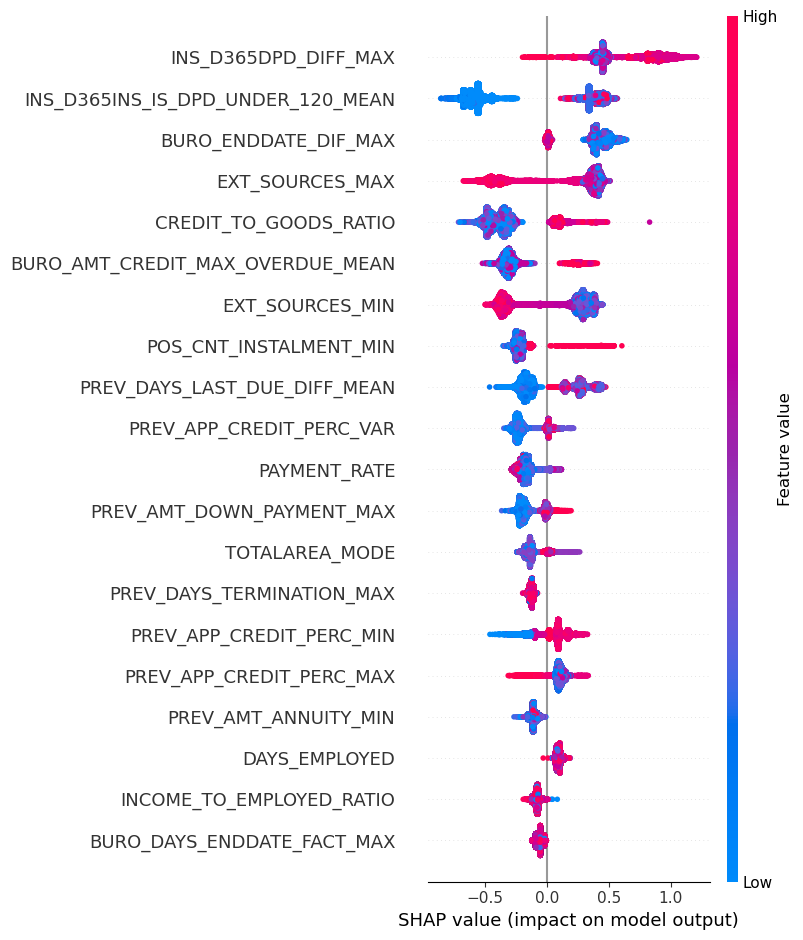

In [102]:
# Créer un fichier texte avant de l'enregistrer
with open("other_file.txt", "w") as f:
    f.write("Ceci est un fichier texte exemple pour l'enregistrement dans MLflow.")

# Log du fichier texte dans MLflow
with mlflow.start_run():
    # Log du modèle LightGBM
    mlflow.lightgbm.log_model(grid_search_lgb.best_estimator_.named_steps['classifier'], "model")

    # Créer une visualisation SHAP
    shap.initjs()  # Initialiser les éléments JS pour SHAP
    shap.summary_plot(shap_values, X_val_df, feature_names=X_val_df.columns, show=False)  # Visualisation SHAP
    
    # Enregistrer la visualisation SHAP
    plt.savefig("shap_summary_plot.png")
    
    # Log de la visualisation SHAP dans MLflow
    mlflow.log_artifact("shap_summary_plot.png")
    
    # Log du fichier texte
    mlflow.log_artifact("other_file.txt")


In [108]:
from lime.lime_tabular import LimeTabularExplainer

# Assurez-vous que X_train est un DataFrame avec des noms de colonnes
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_val_df = pd.DataFrame(X_val, columns=X.columns)

# Initialisation de l'explainer LIME
explainer = LimeTabularExplainer(
    X_train_df.values, 
    feature_names=X_train_df.columns, 
    class_names=['Non Prospect', 'Prospect'], 
    discretize_continuous=True
)

# Sélection d'une instance à expliquer
client_idx = 10  # Par exemple, le 10ème client
exp = explainer.explain_instance(
    X_val_df.iloc[client_idx].values, 
    grid_search_lgb.predict_proba, 
    num_features=10
)

# Visualisation de l'explication locale
exp.show_in_notebook(show_all=False)

In [106]:
!pip install lime

     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     -- ---------------------------------- 20.5/275.7 kB 330.3 kB/s eta 0:00:01
     ----- ------------------------------- 41.0/275.7 kB 393.8 kB/s eta 0:00:01
     ------------- ---------------------- 102.4/275.7 kB 737.3 kB/s eta 0:00:01
     ------------------------ ----------- 184.3/275.7 kB 930.9 kB/s eta 0:00:01
     -------------------------- --------- 204.8/275.7 kB 892.5 kB/s eta 0:00:01
     ------------------------------------ 275.7/275.7 kB 944.8 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283842 sha256=1ba8ec81a52459fb24d05fe6f2dc879c632020d4c0764d9cb259bf1cf5db84f4
  Stored in directory: c:\users\souka\appdata\local\pip\cache\wheels\85\fa\a3\9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [110]:
# Assurez-vous que X_train est un DataFrame avec des noms de colonnes
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_val_df = pd.DataFrame(X_val, columns=X.columns)

# Initialisation de l'explainer LIME
explainer = LimeTabularExplainer(
    X_train_df.values, 
    feature_names=X_train_df.columns, 
    class_names=['Non Prospect', 'Prospect'], 
    discretize_continuous=True
)

# Sélection d'une instance à expliquer
client_idx = 10  # Par exemple, le 10ème client
exp = explainer.explain_instance(
    X_val_df.iloc[client_idx].values, 
    grid_search_lgb.predict_proba, 
    num_features=10
)

# Sauvegarder l'explication LIME en tant que fichier HTML
lime_html_path = "lime_explanation.html"
exp.save_to_file(lime_html_path)

# Enregistrer le modèle et l'explication dans MLflow
with mlflow.start_run():
    # Enregistrer le modèle dans MLflow
    mlflow.sklearn.log_model(grid_search_lgb.best_estimator_, "model")
    
    # Enregistrer l'explication LIME en tant qu'artefact
    mlflow.log_artifact(lime_html_path)
    
    # Vous pouvez aussi loguer d'autres informations (par exemple, des métriques ou des fichiers)
    mlflow.log_param("Client Index", client_idx)
    mlflow.log_param("Features Explained", 10)  # Exemple de paramètre

2024/10/15 11:50:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [114]:
# Démarrer un run MLflow
with mlflow.start_run():
    # Log du modèle LightGBM
    mlflow.lightgbm.log_model(grid_search_lgb.best_estimator_.named_steps['classifier'], "model")
    
    # Log des métriques (exemple)
    mlflow.log_metric("accuracy", accuracy_score(y_val, grid_search_lgb.predict(X_val)))
    
    # Log des artefacts (par exemple, un fichier SHAP)
    shap.summary_plot(shap_values, X_val, feature_names=X_val.columns, show=False)
    plt.savefig("shap_summary_plot.png")
    mlflow.log_artifact("shap_summary_plot.png")
    
    # Log d'autres fichiers si nécessaire
    mlflow.log_artifact("other_file.txt")

2024/10/15 12:12:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


AttributeError: 'numpy.ndarray' object has no attribute 'columns'